# Исследование данных по маркетингу

**Общее описание**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель**

Предсказать вероятность покупки в течение 90 дней

**Задачи**

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc (пороговое значение 0.7)
- Выполнить тестирование

**Описание данных**

*apparel-purchases*

Данные о покупках клиентов по дням и по товарам.
  - client_id идентификатор клиента
  - quantity количество единиц товара
  - price цена товара
  - category_ids идентификаторы категорий
  - date дата покупки
  - message_id идентификатор сообщения из рассылки

*apparel-messages*

Рассылки, которые были отправлены клиентам из таблицы покупок.
  - bulk_campaign_id идентификатор рассылки
  - client_id идентификатор клиента
  - message_id идентификатор сообщения
  - event действие с сообщением (отправлено, открыто, покупка…)
  - channel канал рассылки
  - date дата действия
  - created_at дата-время полностью

*target*
  - client_id идентификатор клиента
  - target клиент совершил покупку в целевом периоде

### Импорты и доп.библиотеки

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostClassifier
from category_encoders.m_estimate import MEstimateEncoder
from lightgbm import LGBMClassifier
from phik.report import plot_correlation_matrix
import shap
import xgboost

In [2]:
# обьявляем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Дополнительные функции

In [3]:
def hist_box_plot(data, x):
    """Функция для построения графика hist и boxplot"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=100)
    fig.suptitle(f'Графики распределения признака {x}')
    sns.histplot(data=data, x=x, bins=50, color=['g'], ax=axes[0])
    axes[0].grid(True, axis='y', linestyle='--')
    sns.boxplot(data=data, x=x, ax=axes[1], color='g')
    axes[1].grid(True, axis='x', linestyle='--')

In [4]:
def model_score(model, X_test, y_test):
    """Оценка производительности модели на тестовой выборке"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=100)
    y_pred = model.predict(X_test)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    preds = model.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=axes[1])
    axes[1].plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
    axes[1].set_title("График ROC-AUC")
    axes[1].legend()

    roc_auc = roc_auc_score(y_test, preds)

    print('ROC-AUC = ', roc_auc)
    print(classification_report(y_test, y_pred))

In [5]:
def cross_params(cross_seach):
    """Визуализация параметров кросс-валидации"""
    df_cg=pd.DataFrame(cross_seach.cv_results_)[
    ['rank_test_score', 'mean_test_score','params', 'mean_fit_time']
    ].sort_values('rank_test_score')[:5].reset_index(drop=True)
    print("Парамерты лучшей модели",cross_seach.best_params_)
    print("ROC-AUC с лучшими гиперпараметрами на кросс-валидации :", cross_seach.best_score_)
    display(df_cg)


In [6]:
# определение популярного значения для агрегаций
get_max = lambda x: x.value_counts(dropna=False).index [0]

In [7]:
def diff_avg(x):
    """Определение средней разницы между покупками в днях"""
    if len(x)<2:
        return 0
    l=[]
    for i in range(len(x)-1):
        l.append((x.iloc[i+1]-x.iloc[i]).days)
    return np.mean(l)

### Загрузка данных

In [8]:
target=pd.read_csv('apparel-target_binary.csv')
target.head(5)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [9]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [10]:
messages=pd.read_csv('apparel-messages.csv', parse_dates=['date','created_at'])
messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [12]:
purchase=pd.read_csv('apparel-purchases.csv', parse_dates=['date'])
purchase.head(5)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [13]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


**Промежуточные выводы:**

- для исследования загрузили 3 датасета с различными наборами данных:
    - target - целевой показатель, пропусков нет типизация корректна.
    - purchase - отражение всех покупок клиентов, 5 признаков без явных пропусков, типизация корректнаю
    - messages - рекламная рассылка по клиентской базе, типизация корректа, пропуски раасмотрим далее.

## Исследование данных

### Target

In [14]:
target.duplicated().sum()

0

0    48888
1      961
Name: target, dtype: int64

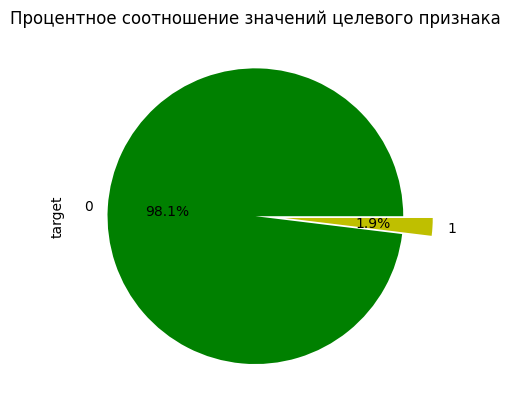

In [15]:
display(target['target'].value_counts())
tlt='Процентное соотношение значений целевого признака'
target['target'].value_counts().plot(kind='pie',
                                     colors=['g', 'y'],
                                     autopct='%.1f%%',
                                     explode=[0, 0.2],
                                     title=tlt);

In [16]:
target.set_index('client_id', inplace=True)
target.index.name=None
target.head()

,target
1515915625468060902,0
1515915625468061003,1
1515915625468061099,0
1515915625468061100,0
1515915625468061170,0


**Результат осмотра данных:**
- дубликатов не обнаружено,
- видим большой дисбаланс данных - только 1.9% покупателей из выборки совершили повторную покупку,
- в выборке 49849 уникальных клиентов

### Messages

In [17]:
messages.duplicated().sum()

48610

Имееем 48 тысяч полных дубликатов, учитывая что каждое сообщение детализировано точной датой, имеет смысл от этих дубликатов избавится, т.к. скорее всего это ошибка выгрузки, которая в дальнейшем даст лишний шум в данных.

In [18]:
messages.drop_duplicates(inplace=True)
messages.shape

(12691188, 7)

In [19]:
for col in messages.columns:
    print(f'Количество пропусков в столбце {col} -', messages[col].isna().sum())# проверка на пропускы

Количество пропусков в столбце bulk_campaign_id - 0
Количество пропусков в столбце client_id - 0
Количество пропусков в столбце message_id - 0
Количество пропусков в столбце event - 0
Количество пропусков в столбце channel - 0
Количество пропусков в столбце date - 0
Количество пропусков в столбце created_at - 0


In [20]:
# посмотрим на количество уникальных id клиентов
len(messages['client_id'].unique())

53329

In [21]:
display(messages['event'].value_counts())

send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: event, dtype: int64

mobile_push    7470472
email          5220716
Name: channel, dtype: int64

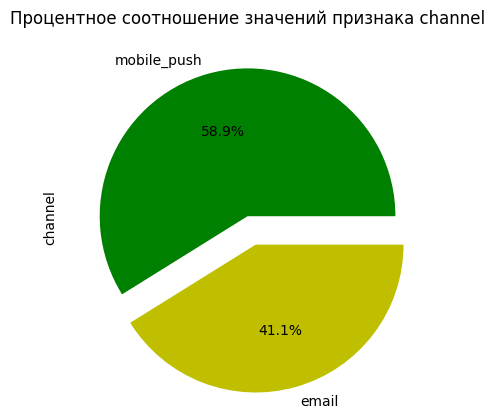

In [22]:
display(messages['channel'].value_counts())
tlt='Процентное соотношение значений признака channel'
messages['channel'].value_counts().plot(kind='pie',
                                     colors=['g', 'y'],
                                     autopct='%.1f%%',
                                     explode=[0, 0.2],
                                     title=tlt);


In [23]:
messages['bulk_campaign_id'].value_counts()

14272    104060
14276     63362
4679      50621
11760     45745
14081     44067
          ...  
548           1
676           1
594           1
657           1
1391          1
Name: bulk_campaign_id, Length: 2709, dtype: int64

In [24]:
messages['date'].value_counts()

2023-06-10    89173
2024-01-26    84242
2023-12-11    82568
2023-12-10    81352
2023-12-26    80116
              ...  
2023-01-08      278
2023-04-11      273
2023-01-07      259
2023-05-09      250
2023-07-02      104
Name: date, Length: 638, dtype: int64

In [25]:
messages['date'].sort_values()

0          2022-05-19
11466      2022-05-19
11467      2022-05-19
11468      2022-05-19
11469      2022-05-19
              ...    
12710832   2024-02-15
12710833   2024-02-15
12710834   2024-02-15
12710826   2024-02-15
12739797   2024-02-15
Name: date, Length: 12691188, dtype: datetime64[ns]

**Результат осмотра данных**:
- удалили 48 тысяч дубликатов из 12739798 наблюдений,
- явных пропусков не обнаружено,
- имеем 53329 уникальных айди клиентов,
- клиенты участвовали в 2709 рекламных кампаниях,в рассылке каждой кампании от 1 до 104060 событий,
- в столбце event рассматриваем 11 возможных явлений, самое популярное send - 9058174, редкое close - 1
- даты рассылки с 2022-05-19 до 2024-02-15, всего 638 дней, количество событий от 104 до 89173 за день
- рассылка производится по 2 каналам - эл.почта и моб.уведомления, дисбаланса между каналами на наблюдается.


### Purchase

In [26]:
purchase.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [27]:
purchase.duplicated().sum()

73020

73 тысячи дубликатов для датафрейма в 202208 наблюдений это много для удаления, учитывая что наблюдения не детализированы по времени избавляться от них точно не стоит.

In [28]:
purchase['category_ids'].value_counts()

['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '27', '278', '471']              1
['5562', '5589', '5613', '1726']       1
['1', '8', '280', '710']               1
['5562', '5597', '5696', '751']        1
['4', '44', '1600']                    1
Name: category_ids, Length: 933, dtype: int64

In [29]:
#заполним отсутствующие категории единообразно
purchase['category_ids'].replace('[]','[None]', inplace=True)
purchase['category_ids'].value_counts()

['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
[None]                              6843
['4', '28', '244', '432']           6821
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '6013', '1607']          1
['5562', '5632', '5603', '1095']       1
['5562', '5589', '5623', '1775']       1
['5562', '5697', '5651', '1153']       1
['4', '44', '1600']                    1
Name: category_ids, Length: 932, dtype: int64

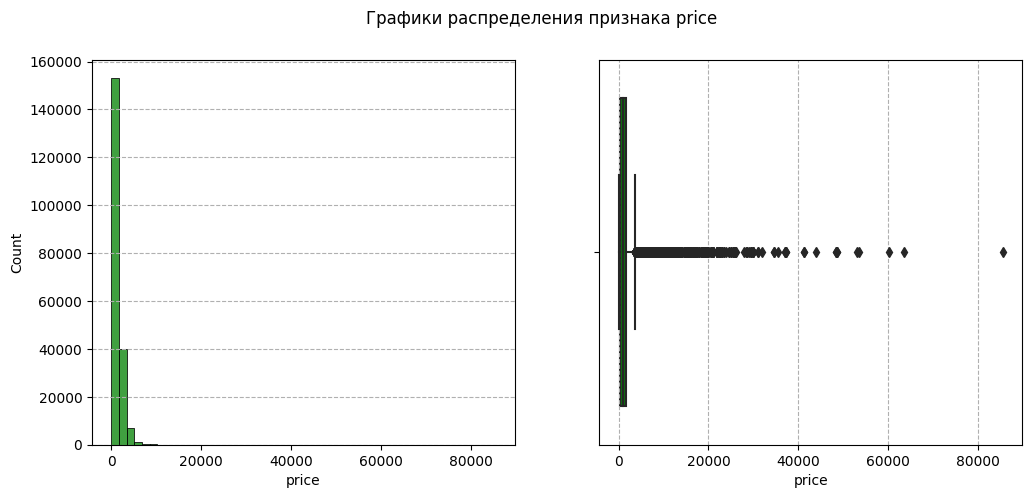

In [30]:
hist_box_plot(purchase,'price')

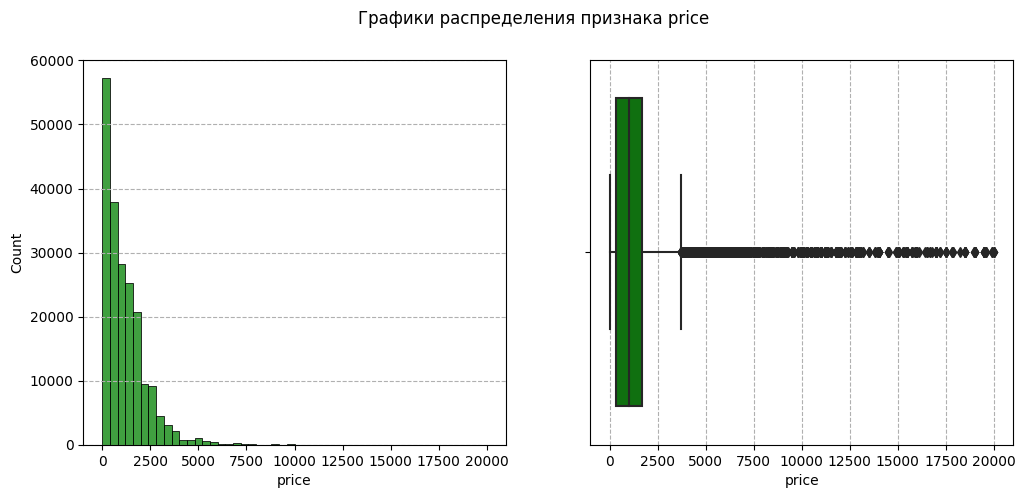

In [31]:
hist_box_plot(purchase.query('price<20000'),'price')

In [32]:
display(purchase.query('price>80000'))
purchase[purchase['category_ids']=="['4', '29', '313', '1574']"]

,client_id,quantity,price,category_ids,date,message_id
186736,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711


,client_id,quantity,price,category_ids,date,message_id
12994,1515915625494529950,1,16499.0,"['4', '29', '313', '1574']",2022-06-10,1515915625494529950-4832-62a1969869bb0
98921,1515915625474387397,1,16660.0,"['4', '29', '313', '1574']",2023-04-05,1515915625474387397-11527-642c1f61cbd80
98922,1515915625474387397,1,16660.0,"['4', '29', '313', '1574']",2023-04-05,1515915625474387397-11527-642c1f61cbd80
142203,1515915625468081528,1,22680.0,"['4', '29', '313', '1574']",2023-06-20,1515915625468081528-13372-649150b651ec0
142204,1515915625468081528,1,22680.0,"['4', '29', '313', '1574']",2023-06-20,1515915625468081528-13372-649150b651ec0
155219,1515915625590727241,1,15049.0,"['4', '29', '313', '1574']",2023-07-07,1515915625776568054-13456-64a7dde275979
155220,1515915625590727241,1,15049.0,"['4', '29', '313', '1574']",2023-07-07,1515915625776568054-13456-64a7dde275979
159176,1515915625502430512,1,13999.0,"['4', '29', '313', '1574']",2023-07-13,1515915625776547099-13471-64abf25c6fe22
159177,1515915625502430512,1,13999.0,"['4', '29', '313', '1574']",2023-07-13,1515915625776547099-13471-64abf25c6fe22
159465,1515915625776547099,1,19999.0,"['4', '29', '313', '1574']",2023-07-13,1515915625776547099-13471-64abf25c6fe22


Распределение суммы покупок скошенное с хвостом справа, есть достаточное количество выбросов. есть определенное количество 'дорогих' товаров, но от категории и количества они не зависят.
Учитывая,что мы ничего не знаем о специфике товара, бонусной и скидочной программе - не будем удалять наблюдения с большими ценами.

In [33]:
purchase['date'].sort_values()

0        2022-05-16
20       2022-05-16
21       2022-05-16
22       2022-05-16
23       2022-05-16
            ...    
201855   2024-02-16
201854   2024-02-16
201853   2024-02-16
201883   2024-02-16
202207   2024-02-16
Name: date, Length: 202208, dtype: datetime64[ns]

In [34]:
purchase['quantity'].value_counts()

1     201323
2        751
3         94
4         12
6          5
10         4
5          3
15         3
20         3
9          2
25         2
30         2
7          1
8          1
13         1
18         1
Name: quantity, dtype: int64

In [35]:
len(purchase['client_id'].unique())

49849

**Результаты осмотра данных**
- пропуски в данных не обнаружены, в категории все отсутствующие данные отмечены заглушкой [None],
- обнаружено 73020 дубликатов, но учитывая, что детализация времени покупки весьма относительна(только дата), а основная часть покупок совершается по 1 ед.товара, будем считать это особенностями разбивки платежной/ученой системы их не будем удалять.
- имеем 932 категории товаров, разбитых по 0-4 индекса, попялярность категорий от 1 до 8626,
- невозможно сказать, что цена товара привязана к категории, т.к. товар одной категории может стоить от 2879 до 85499, при одинаковом количеств в заказе. Бонусная это система или скидки - сложно ответить при наших данныхю
- диапазон дат от 2022-05-16 до 2024-02-16, 
- уникальных клиентов - 49849.

## Feature Engineering

In [36]:
tg=set(target.index.to_list())
ms=set(messages['client_id'].unique())
pr=set(purchase['client_id'].unique())

In [37]:
tg==pr

True

Все покупатели таргета есть в покупках.

In [38]:
tg==ms

False

In [39]:
all=tg.intersection(ms)
len(all)

41982

А вот в рассылках есть не все, но мы планируем в исследовании использовать информацию из датафрейма с рассылками, поэтому придется видимо сократить датафрейм target.

#### FE messages

##### Общая статистика рассылок

In [40]:
#создадим общую сводную таблицу, отражающую сколько и каких событий, случилось с каждым клиентом
client_event_count=messages.pivot_table(index='client_id', columns='event', values='message_id', aggfunc='count')
client_event_count.index.name=None
client_event_count.columns.name='client_id'
print(client_event_count.shape)
client_event_count.head(10)

(53329, 11)


client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
1515915625468060902,10.0,NaN,NaN,NaN,NaN,35.0,5.0,126.0,NaN,NaN,1.0
1515915625468061003,5.0,NaN,NaN,NaN,NaN,5.0,1.0,154.0,NaN,NaN,NaN
1515915625468061099,8.0,NaN,NaN,2.0,NaN,51.0,NaN,215.0,NaN,NaN,NaN
1515915625468061100,1.0,NaN,NaN,1.0,NaN,157.0,1.0,267.0,1.0,NaN,NaN
1515915625468061170,16.0,NaN,NaN,NaN,NaN,31.0,3.0,243.0,NaN,NaN,NaN
1515915625468061514,12.0,NaN,NaN,NaN,NaN,17.0,1.0,150.0,NaN,NaN,NaN
1515915625468061877,5.0,NaN,NaN,NaN,NaN,50.0,1.0,173.0,NaN,NaN,NaN
1515915625468061899,3.0,NaN,NaN,NaN,NaN,15.0,NaN,111.0,NaN,NaN,NaN
1515915625468061975,7.0,NaN,NaN,NaN,1.0,17.0,1.0,154.0,NaN,NaN,NaN
1515915625468061994,9.0,NaN,NaN,NaN,NaN,21.0,2.0,346.0,NaN,NaN,NaN


In [41]:
# сводная таблица для расчета количества по каким каналам получаются уведомления клиентом
client_channel_count=messages.pivot_table(index='client_id', columns='channel', values='message_id', aggfunc='count')
client_channel_count.index.name=None
client_channel_count.columns.name='client_id'
print(client_channel_count.shape)
client_channel_count.head()

(53329, 2)


client_id,email,mobile_push
1515915625468060902,177.0,NaN
1515915625468061003,165.0,NaN
1515915625468061099,182.0,94.0
1515915625468061100,NaN,428.0
1515915625468061170,202.0,91.0


In [42]:
#общее количество уведомлений на клиеента и дата последнего
client_all_count=messages.groupby('client_id').agg({'message_id':'count',
                                                    'date': 'max',
                                                     })
client_all_count.index.name=None
client_all_count.rename(columns={'date':'date_last_message',
                                  'message_id':'message_count',
                                  }, inplace=True)
print(client_all_count.shape)
client_all_count.head(10)

(53329, 2)


,message_count,date_last_message
1515915625468060902,177,2024-01-19
1515915625468061003,165,2024-02-13
1515915625468061099,276,2024-02-13
1515915625468061100,428,2024-02-15
1515915625468061170,293,2024-02-15
1515915625468061514,180,2024-02-13
1515915625468061877,229,2024-02-15
1515915625468061899,129,2024-02-13
1515915625468061975,180,2024-02-13
1515915625468061994,378,2024-02-14


In [43]:
# обьединим все в общую сводную таблицу, хакретизующую информационное взаимодействие с каждым клиентом
df_all_message=pd.merge(client_channel_count, client_event_count, left_index=True, right_index=True, how='left')
df_all_message=df_all_message.merge(client_all_count, left_index=True, right_index=True, how='left')
print(df_all_message.shape)
df_all_message.head()

(53329, 15)


,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,message_count,date_last_message
1515915625468060902,177.0,NaN,10.0,NaN,NaN,NaN,NaN,35.0,5.0,126.0,NaN,NaN,1.0,177,2024-01-19
1515915625468061003,165.0,NaN,5.0,NaN,NaN,NaN,NaN,5.0,1.0,154.0,NaN,NaN,NaN,165,2024-02-13
1515915625468061099,182.0,94.0,8.0,NaN,NaN,2.0,NaN,51.0,NaN,215.0,NaN,NaN,NaN,276,2024-02-13
1515915625468061100,NaN,428.0,1.0,NaN,NaN,1.0,NaN,157.0,1.0,267.0,1.0,NaN,NaN,428,2024-02-15
1515915625468061170,202.0,91.0,16.0,NaN,NaN,NaN,NaN,31.0,3.0,243.0,NaN,NaN,NaN,293,2024-02-15


Из датафрейма messages создали общую сводную наблицу, характеризующую информационное взаимодействие компании с каждым клиентом.

In [44]:
# удалим лишнее
del messages, client_channel_count, client_event_count, client_all_count

#### FE purchase

In [45]:
purchase.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Создадим таблицу отражающую, сколько раз клиент вернулся в магазин для совершения новых покупок.

In [46]:
purchase_2=purchase[['client_id', 'date']].drop_duplicates()
purchase_2.head()

,client_id,date
0,1515915625468169594,2022-05-16
2,1515915625471138230,2022-05-16
5,1515915625471640575,2022-05-16
6,1515915625490211585,2022-05-16
7,1515915625490739153,2022-05-16


In [47]:
day_buy=purchase_2.groupby('client_id').agg({'date':'count',})
day_buy.index.name=None
day_buy.rename(columns={'date':'count_diff_dt',}, inplace=True)
print(day_buy.shape)
day_buy.head()

(49849, 1)


,count_diff_dt
1515915625468060902,1
1515915625468061003,1
1515915625468061099,1
1515915625468061100,1
1515915625468061170,3


In [48]:
# попробуем посчитать среднюю разницу между днями совершения покупок
day_buy_2=purchase_2.groupby('client_id').agg({'date':diff_avg,})
day_buy_2.index.name=None
day_buy_2.rename(columns={'date':'avg_div_date',}, inplace=True)
print(day_buy_2.shape)
day_buy_2.head()

(49849, 1)


,avg_div_date
1515915625468060902,0.0
1515915625468061003,0.0
1515915625468061099,0.0
1515915625468061100,0.0
1515915625468061170,41.5


In [49]:
day_buy=day_buy.merge(day_buy_2, left_index=True, right_index=True, how='left')
day_buy.head()

,count_diff_dt,avg_div_date
1515915625468060902,1,0.0
1515915625468061003,1,0.0
1515915625468061099,1,0.0
1515915625468061100,1,0.0
1515915625468061170,3,41.5


Посчитаем общую сумму купленных товаров, общую сумму потраченных денег, последнюю дату покупки, популярную категорию товаров,количество уникальных категорий, и категорию последней покупки для каждого клиента.

In [50]:
client_pur_count_1=purchase.groupby('client_id').agg({
                                                    'quantity':'sum',
                                                    'price':'sum',
                                                    'date': 'max',
                                                    'category_ids': [get_max],})
client_pur_count_1.index.name=None
client_pur_count_1.columns = client_pur_count_1.columns.map(''.join)
client_pur_count_1.rename(columns={'datemax':'date_last_purchase',
                                  'pricesum':'sum_all_purchase',
                                  'quantitysum':'sum_pur_quantity',
                                  'category_ids<lambda>':'category_popular',
                                  }, inplace=True)
print(client_pur_count_1.shape)
client_pur_count_1.sample(10)

(49849, 4)


,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular
1515915625821124009,18,25641.0,2024-02-12,"['2', '18', '61', '661']"
1515915625586036282,6,5176.0,2023-02-22,"['2', '18', '258', '441']"
1515915625487635530,2,2998.0,2023-12-09,"['4', '28', '104', '429']"
1515915625592100050,4,8908.0,2022-11-16,"['4', '28', '44', '493']"
1515915625557169731,6,7996.0,2022-06-23,"['4', '28', '57', '431']"
1515915625501244391,12,8793.0,2023-06-10,"['5562', '5630', '5667', '551']"
1515915625468148737,3,8497.0,2022-08-07,"['4', '28', '57', '431']"
1515915625468085036,1,2999.0,2022-07-11,"['2', '18', '61', '661']"
1515915625494971214,2,1398.0,2023-12-22,"['4', '28', '275', '421']"
1515915625472400952,18,27438.0,2024-01-12,"['2', '18', '155', '439']"


In [51]:
client_pur_count_2=purchase.groupby('client_id').agg({
                                                    'category_ids':'nunique',})
client_pur_count_2.rename(columns={
                                  'category_ids':'category_count',}, inplace=True)
print(client_pur_count_2.shape)
client_pur_count_2.sample(10)

(49849, 1)


,category_count
client_id,
1515915625484560369,1
1515915625491844605,1
1515915625625087657,2
1515915625565391647,3
1515915625491381434,1
1515915625550600414,1
1515915625498787108,1
1515915625492912412,2
1515915625917560205,1


In [52]:
client_pur_count_3=purchase.groupby('client_id').agg({
                                                    'category_ids':'last',})
client_pur_count_3.index.name=None
client_pur_count_3.rename(columns={
                                  'category_ids':'last_category'}, inplace=True)
print(client_pur_count_3.shape)
client_pur_count_3.sample(10)

(49849, 1)


,last_category
1515915625767127490,"['4', '28', '275', '421']"
1515915625588481106,"['4', '28', '239', '418']"
1515915625489538450,"['4', '28', '260', '420']"
1515915625491013285,"['4', '28', '275', '421']"
1515915625560533586,"['4', '28', '57', '431']"
1515915625474309216,"['4', '28', '57', '431']"
1515915625494595822,"['2', '18', '212', '726']"
1515915625883984310,"['2', '18', '267', '443']"
1515915625511453782,"['5562', '5631', '5608', '561']"
1515915625656345666,"['4', '28', '254', '680']"


In [53]:
client_pur_count_1=client_pur_count_1.merge(client_pur_count_2, left_index=True, right_index=True, how='left')
client_pur_count_1=client_pur_count_1.merge(client_pur_count_3, left_index=True, right_index=True, how='left')
client_pur_count_1.head()

,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular,category_count,last_category
1515915625468060902,7,6993.0,2022-05-27,"['4', '28', '260', '420']",5,"['4', '28', '244', '432']"
1515915625468061003,7,16235.0,2023-01-04,"['4', '28', '249', '615']",1,"['4', '28', '249', '615']"
1515915625468061099,1,299.0,2022-05-17,"['4', '28', '290', '424']",1,"['4', '28', '290', '424']"
1515915625468061100,2,2098.0,2024-02-10,"['4', '27', '1828', '5717']",1,"['4', '27', '1828', '5717']"
1515915625468061170,19,33601.0,2023-06-17,"['4', '28', '260', '420']",4,"['4', '28', '244', '432']"


In [54]:
pur_info=pd.merge(client_pur_count_1, day_buy, left_index=True, right_index=True, how='left')
print(pur_info.shape)
pur_info.head()

(49849, 8)


,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular,category_count,last_category,count_diff_dt,avg_div_date
1515915625468060902,7,6993.0,2022-05-27,"['4', '28', '260', '420']",5,"['4', '28', '244', '432']",1,0.0
1515915625468061003,7,16235.0,2023-01-04,"['4', '28', '249', '615']",1,"['4', '28', '249', '615']",1,0.0
1515915625468061099,1,299.0,2022-05-17,"['4', '28', '290', '424']",1,"['4', '28', '290', '424']",1,0.0
1515915625468061100,2,2098.0,2024-02-10,"['4', '27', '1828', '5717']",1,"['4', '27', '1828', '5717']",1,0.0
1515915625468061170,19,33601.0,2023-06-17,"['4', '28', '260', '420']",4,"['4', '28', '244', '432']",3,41.5


Составили покупательский портрет каждого клиента, отразив часто покупаемую категорию товаров, частоту покупок, количество категорий покупок, и суммы заказов и потраченных денежных средств.

### Совмещение данных в один датафрейм

In [55]:
df_main=pd.merge(target, pur_info, left_index=True, right_index=True, how='inner')
print(df_main.shape)
df_main.head()

(49849, 9)


,target,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular,category_count,last_category,count_diff_dt,avg_div_date
1515915625468060902,0,7,6993.0,2022-05-27,"['4', '28', '260', '420']",5,"['4', '28', '244', '432']",1,0.0
1515915625468061003,1,7,16235.0,2023-01-04,"['4', '28', '249', '615']",1,"['4', '28', '249', '615']",1,0.0
1515915625468061099,0,1,299.0,2022-05-17,"['4', '28', '290', '424']",1,"['4', '28', '290', '424']",1,0.0
1515915625468061100,0,2,2098.0,2024-02-10,"['4', '27', '1828', '5717']",1,"['4', '27', '1828', '5717']",1,0.0
1515915625468061170,0,19,33601.0,2023-06-17,"['4', '28', '260', '420']",4,"['4', '28', '244', '432']",3,41.5


In [56]:
df_main=df_main.merge(df_all_message, left_index=True, right_index=True, how='inner')
print(df_main.shape)
df_main.head()

(41982, 24)


,target,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular,category_count,last_category,count_diff_dt,avg_div_date,email,...,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,message_count,date_last_message
1515915625468060902,0,7,6993.0,2022-05-27,"['4', '28', '260', '420']",5,"['4', '28', '244', '432']",1,0.0,177.0,...,NaN,NaN,35.0,5.0,126.0,NaN,NaN,1.0,177,2024-01-19
1515915625468061003,1,7,16235.0,2023-01-04,"['4', '28', '249', '615']",1,"['4', '28', '249', '615']",1,0.0,165.0,...,NaN,NaN,5.0,1.0,154.0,NaN,NaN,NaN,165,2024-02-13
1515915625468061099,0,1,299.0,2022-05-17,"['4', '28', '290', '424']",1,"['4', '28', '290', '424']",1,0.0,182.0,...,2.0,NaN,51.0,NaN,215.0,NaN,NaN,NaN,276,2024-02-13
1515915625468061100,0,2,2098.0,2024-02-10,"['4', '27', '1828', '5717']",1,"['4', '27', '1828', '5717']",1,0.0,NaN,...,1.0,NaN,157.0,1.0,267.0,1.0,NaN,NaN,428,2024-02-15
1515915625468061170,0,19,33601.0,2023-06-17,"['4', '28', '260', '420']",4,"['4', '28', '244', '432']",3,41.5,202.0,...,NaN,NaN,31.0,3.0,243.0,NaN,NaN,NaN,293,2024-02-15


In [57]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41982 entries, 1515915625468060902 to 1515915626010261344
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   target              41982 non-null  int64         
 1   sum_pur_quantity    41982 non-null  int64         
 2   sum_all_purchase    41982 non-null  float64       
 3   date_last_purchase  41982 non-null  datetime64[ns]
 4   category_popular    41982 non-null  object        
 5   category_count      41982 non-null  int64         
 6   last_category       41982 non-null  object        
 7   count_diff_dt       41982 non-null  int64         
 8   avg_div_date        41982 non-null  float64       
 9   email               31895 non-null  float64       
 10  mobile_push         30359 non-null  float64       
 11  click               39458 non-null  float64       
 12  close               1 non-null      float64       
 13  complain      

In [58]:
df_main.duplicated().sum()

0

Дубликатов не обнаружено, размерность датасета для исследования уменьшена, т.к. рассматривать будем только тех покупатей кто отражен в маркетинговых рассылках.

Заполним пропуски в событиях нулями.

In [59]:
list_columns=['click',
              'complain',
              'hard_bounce',
              'hbq_spam',
              'open',
              'purchase',
              'send',
              'soft_bounce',
              'unsubscribe',
              'mobile_push',
              'email',
              'close',
              'subscribe']

In [60]:
for column in list_columns:
    df_main[column].fillna(0, inplace=True)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41982 entries, 1515915625468060902 to 1515915626010261344
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   target              41982 non-null  int64         
 1   sum_pur_quantity    41982 non-null  int64         
 2   sum_all_purchase    41982 non-null  float64       
 3   date_last_purchase  41982 non-null  datetime64[ns]
 4   category_popular    41982 non-null  object        
 5   category_count      41982 non-null  int64         
 6   last_category       41982 non-null  object        
 7   count_diff_dt       41982 non-null  int64         
 8   avg_div_date        41982 non-null  float64       
 9   email               41982 non-null  float64       
 10  mobile_push         41982 non-null  float64       
 11  click               41982 non-null  float64       
 12  close               41982 non-null  float64       
 13  complain      

In [61]:
date_now=pd.to_datetime('2024-10-18')
date_now

Timestamp('2024-10-18 00:00:00')

In [62]:
# переводим временные колонки в дни
df_main['last_purchase_days']=(date_now-df_main['date_last_purchase']).dt.days
df_main['last_mes_days']=(date_now-df_main['date_last_message']).dt.days
df_main.head()

,target,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular,category_count,last_category,count_diff_dt,avg_div_date,email,...,open,purchase,send,soft_bounce,subscribe,unsubscribe,message_count,date_last_message,last_purchase_days,last_mes_days
1515915625468060902,0,7,6993.0,2022-05-27,"['4', '28', '260', '420']",5,"['4', '28', '244', '432']",1,0.0,177.0,...,35.0,5.0,126.0,0.0,0.0,1.0,177,2024-01-19,875,273
1515915625468061003,1,7,16235.0,2023-01-04,"['4', '28', '249', '615']",1,"['4', '28', '249', '615']",1,0.0,165.0,...,5.0,1.0,154.0,0.0,0.0,0.0,165,2024-02-13,653,248
1515915625468061099,0,1,299.0,2022-05-17,"['4', '28', '290', '424']",1,"['4', '28', '290', '424']",1,0.0,182.0,...,51.0,0.0,215.0,0.0,0.0,0.0,276,2024-02-13,885,248
1515915625468061100,0,2,2098.0,2024-02-10,"['4', '27', '1828', '5717']",1,"['4', '27', '1828', '5717']",1,0.0,0.0,...,157.0,1.0,267.0,1.0,0.0,0.0,428,2024-02-15,251,246
1515915625468061170,0,19,33601.0,2023-06-17,"['4', '28', '260', '420']",4,"['4', '28', '244', '432']",3,41.5,202.0,...,31.0,3.0,243.0,0.0,0.0,0.0,293,2024-02-15,489,246


Добавим признак - статус клиента, тот кто совершил покупки в разные даты, будет считаться постоянным клиентом.

In [63]:
df_main['client_status']=df_main['count_diff_dt'].apply(lambda x: 'new' if x==1 else 'constant ')
df_main.head()

,target,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular,category_count,last_category,count_diff_dt,avg_div_date,email,...,purchase,send,soft_bounce,subscribe,unsubscribe,message_count,date_last_message,last_purchase_days,last_mes_days,client_status
1515915625468060902,0,7,6993.0,2022-05-27,"['4', '28', '260', '420']",5,"['4', '28', '244', '432']",1,0.0,177.0,...,5.0,126.0,0.0,0.0,1.0,177,2024-01-19,875,273,new
1515915625468061003,1,7,16235.0,2023-01-04,"['4', '28', '249', '615']",1,"['4', '28', '249', '615']",1,0.0,165.0,...,1.0,154.0,0.0,0.0,0.0,165,2024-02-13,653,248,new
1515915625468061099,0,1,299.0,2022-05-17,"['4', '28', '290', '424']",1,"['4', '28', '290', '424']",1,0.0,182.0,...,0.0,215.0,0.0,0.0,0.0,276,2024-02-13,885,248,new
1515915625468061100,0,2,2098.0,2024-02-10,"['4', '27', '1828', '5717']",1,"['4', '27', '1828', '5717']",1,0.0,0.0,...,1.0,267.0,1.0,0.0,0.0,428,2024-02-15,251,246,new
1515915625468061170,0,19,33601.0,2023-06-17,"['4', '28', '260', '420']",4,"['4', '28', '244', '432']",3,41.5,202.0,...,3.0,243.0,0.0,0.0,0.0,293,2024-02-15,489,246,constant


Выразим события как положительные-отрицательные, а так же посчитаем для якаждого клиента отношения всех рассылок к рассылкам с положительным/отрицательным статусом.

In [64]:
df_main['good_event']=df_main['click']+df_main['open']+df_main['purchase']+df_main['subscribe']
df_main['bad_event']=df_main['hard_bounce']+df_main['soft_bounce']+df_main['unsubscribe']+df_main['hbq_spam']+df_main['complain']+df_main['close']

df_main['good_ratio']=df_main['good_event']/df_main['message_count']
df_main['bad_ratio']=df_main['bad_event']/df_main['message_count']

df_main.head()


,target,sum_pur_quantity,sum_all_purchase,date_last_purchase,category_popular,category_count,last_category,count_diff_dt,avg_div_date,email,...,unsubscribe,message_count,date_last_message,last_purchase_days,last_mes_days,client_status,good_event,bad_event,good_ratio,bad_ratio
1515915625468060902,0,7,6993.0,2022-05-27,"['4', '28', '260', '420']",5,"['4', '28', '244', '432']",1,0.0,177.0,...,1.0,177,2024-01-19,875,273,new,50.0,1.0,0.282486,0.005650
1515915625468061003,1,7,16235.0,2023-01-04,"['4', '28', '249', '615']",1,"['4', '28', '249', '615']",1,0.0,165.0,...,0.0,165,2024-02-13,653,248,new,11.0,0.0,0.066667,0.000000
1515915625468061099,0,1,299.0,2022-05-17,"['4', '28', '290', '424']",1,"['4', '28', '290', '424']",1,0.0,182.0,...,0.0,276,2024-02-13,885,248,new,59.0,2.0,0.213768,0.007246
1515915625468061100,0,2,2098.0,2024-02-10,"['4', '27', '1828', '5717']",1,"['4', '27', '1828', '5717']",1,0.0,0.0,...,0.0,428,2024-02-15,251,246,new,159.0,2.0,0.371495,0.004673
1515915625468061170,0,19,33601.0,2023-06-17,"['4', '28', '260', '420']",4,"['4', '28', '244', '432']",3,41.5,202.0,...,0.0,293,2024-02-15,489,246,constant,50.0,0.0,0.170648,0.000000


In [65]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41982 entries, 1515915625468060902 to 1515915626010261344
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   target              41982 non-null  int64         
 1   sum_pur_quantity    41982 non-null  int64         
 2   sum_all_purchase    41982 non-null  float64       
 3   date_last_purchase  41982 non-null  datetime64[ns]
 4   category_popular    41982 non-null  object        
 5   category_count      41982 non-null  int64         
 6   last_category       41982 non-null  object        
 7   count_diff_dt       41982 non-null  int64         
 8   avg_div_date        41982 non-null  float64       
 9   email               41982 non-null  float64       
 10  mobile_push         41982 non-null  float64       
 11  click               41982 non-null  float64       
 12  close               41982 non-null  float64       
 13  complain      

In [66]:
df_main.columns

Index(['target', 'sum_pur_quantity', 'sum_all_purchase', 'date_last_purchase',
       'category_popular', 'category_count', 'last_category', 'count_diff_dt',
       'avg_div_date', 'email', 'mobile_push', 'click', 'close', 'complain',
       'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce',
       'subscribe', 'unsubscribe', 'message_count', 'date_last_message',
       'last_purchase_days', 'last_mes_days', 'client_status', 'good_event',
       'bad_event', 'good_ratio', 'bad_ratio'],
      dtype='object')

**Предварительные выводы:**
- обьединили все информационные датафреймы в один общий сводный, отражающий информацию по каждому клиенту,
- итоговый датафрейм состоит из 41982 наблюдений,т.к информацию по маркетинговым рассылкам нам предоставили не повсем клиентам,
- новые признаки:
    - 'target' - целевая переменная,
    - 'sum_pur_quantity'- общая сумма купленных товаров,
    - 'sum_all_purchase' - общая сумма денег потраченных клиентом,
    - 'category_popular' - попуярная у клиента категория товаров,
    - 'category_count' - количество покупаемых клиентомкатегорий товаров,
    - 'last_category' - категория последнего купленного товара,
    - 'count_diff_dt' -количетво повторных покупок клиента,
    - 'avg_div_date' - средняя временная разница между покупками,
    - 'email', 'mobile_push', 'click', 'close', 'complain', 'hard_bounce','hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe','unsubscribe' - сводная информация по рассылке для клиента,
    - 'message_count'- общее количетво полученных клиентом сообщений,
    - 'last_purchase_days' - последняя дата покупки в днях,
    - 'last_mes_days' - последняя дама собщения клиенту в днях,
    - 'client_status' - статус клиента (постоянный или новый),
    - 'good_event', 'bad_event', 'good_ratio', 'bad_ratio' - количество и отношения позитивных/негативных событий рассылки для клиента.

### Корреляционный анализ

In [67]:
df_main.drop(columns=['date_last_purchase',
                      'date_last_message'], inplace=True)

In [68]:
df_main.columns

Index(['target', 'sum_pur_quantity', 'sum_all_purchase', 'category_popular',
       'category_count', 'last_category', 'count_diff_dt', 'avg_div_date',
       'email', 'mobile_push', 'click', 'close', 'complain', 'hard_bounce',
       'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe',
       'unsubscribe', 'message_count', 'last_purchase_days', 'last_mes_days',
       'client_status', 'good_event', 'bad_event', 'good_ratio', 'bad_ratio'],
      dtype='object')

In [69]:
phik_col=df_main.drop(['target',
                       'category_popular',
                       'last_category', 
                       #'last_bulk_id',
                       #'last_channel', 
                       'client_status'
                       ], axis=1).columns.to_list()

In [70]:
phik_col

['sum_pur_quantity',
 'sum_all_purchase',
 'category_count',
 'count_diff_dt',
 'avg_div_date',
 'email',
 'mobile_push',
 'click',
 'close',
 'complain',
 'hard_bounce',
 'hbq_spam',
 'open',
 'purchase',
 'send',
 'soft_bounce',
 'subscribe',
 'unsubscribe',
 'message_count',
 'last_purchase_days',
 'last_mes_days',
 'good_event',
 'bad_event',
 'good_ratio',
 'bad_ratio']

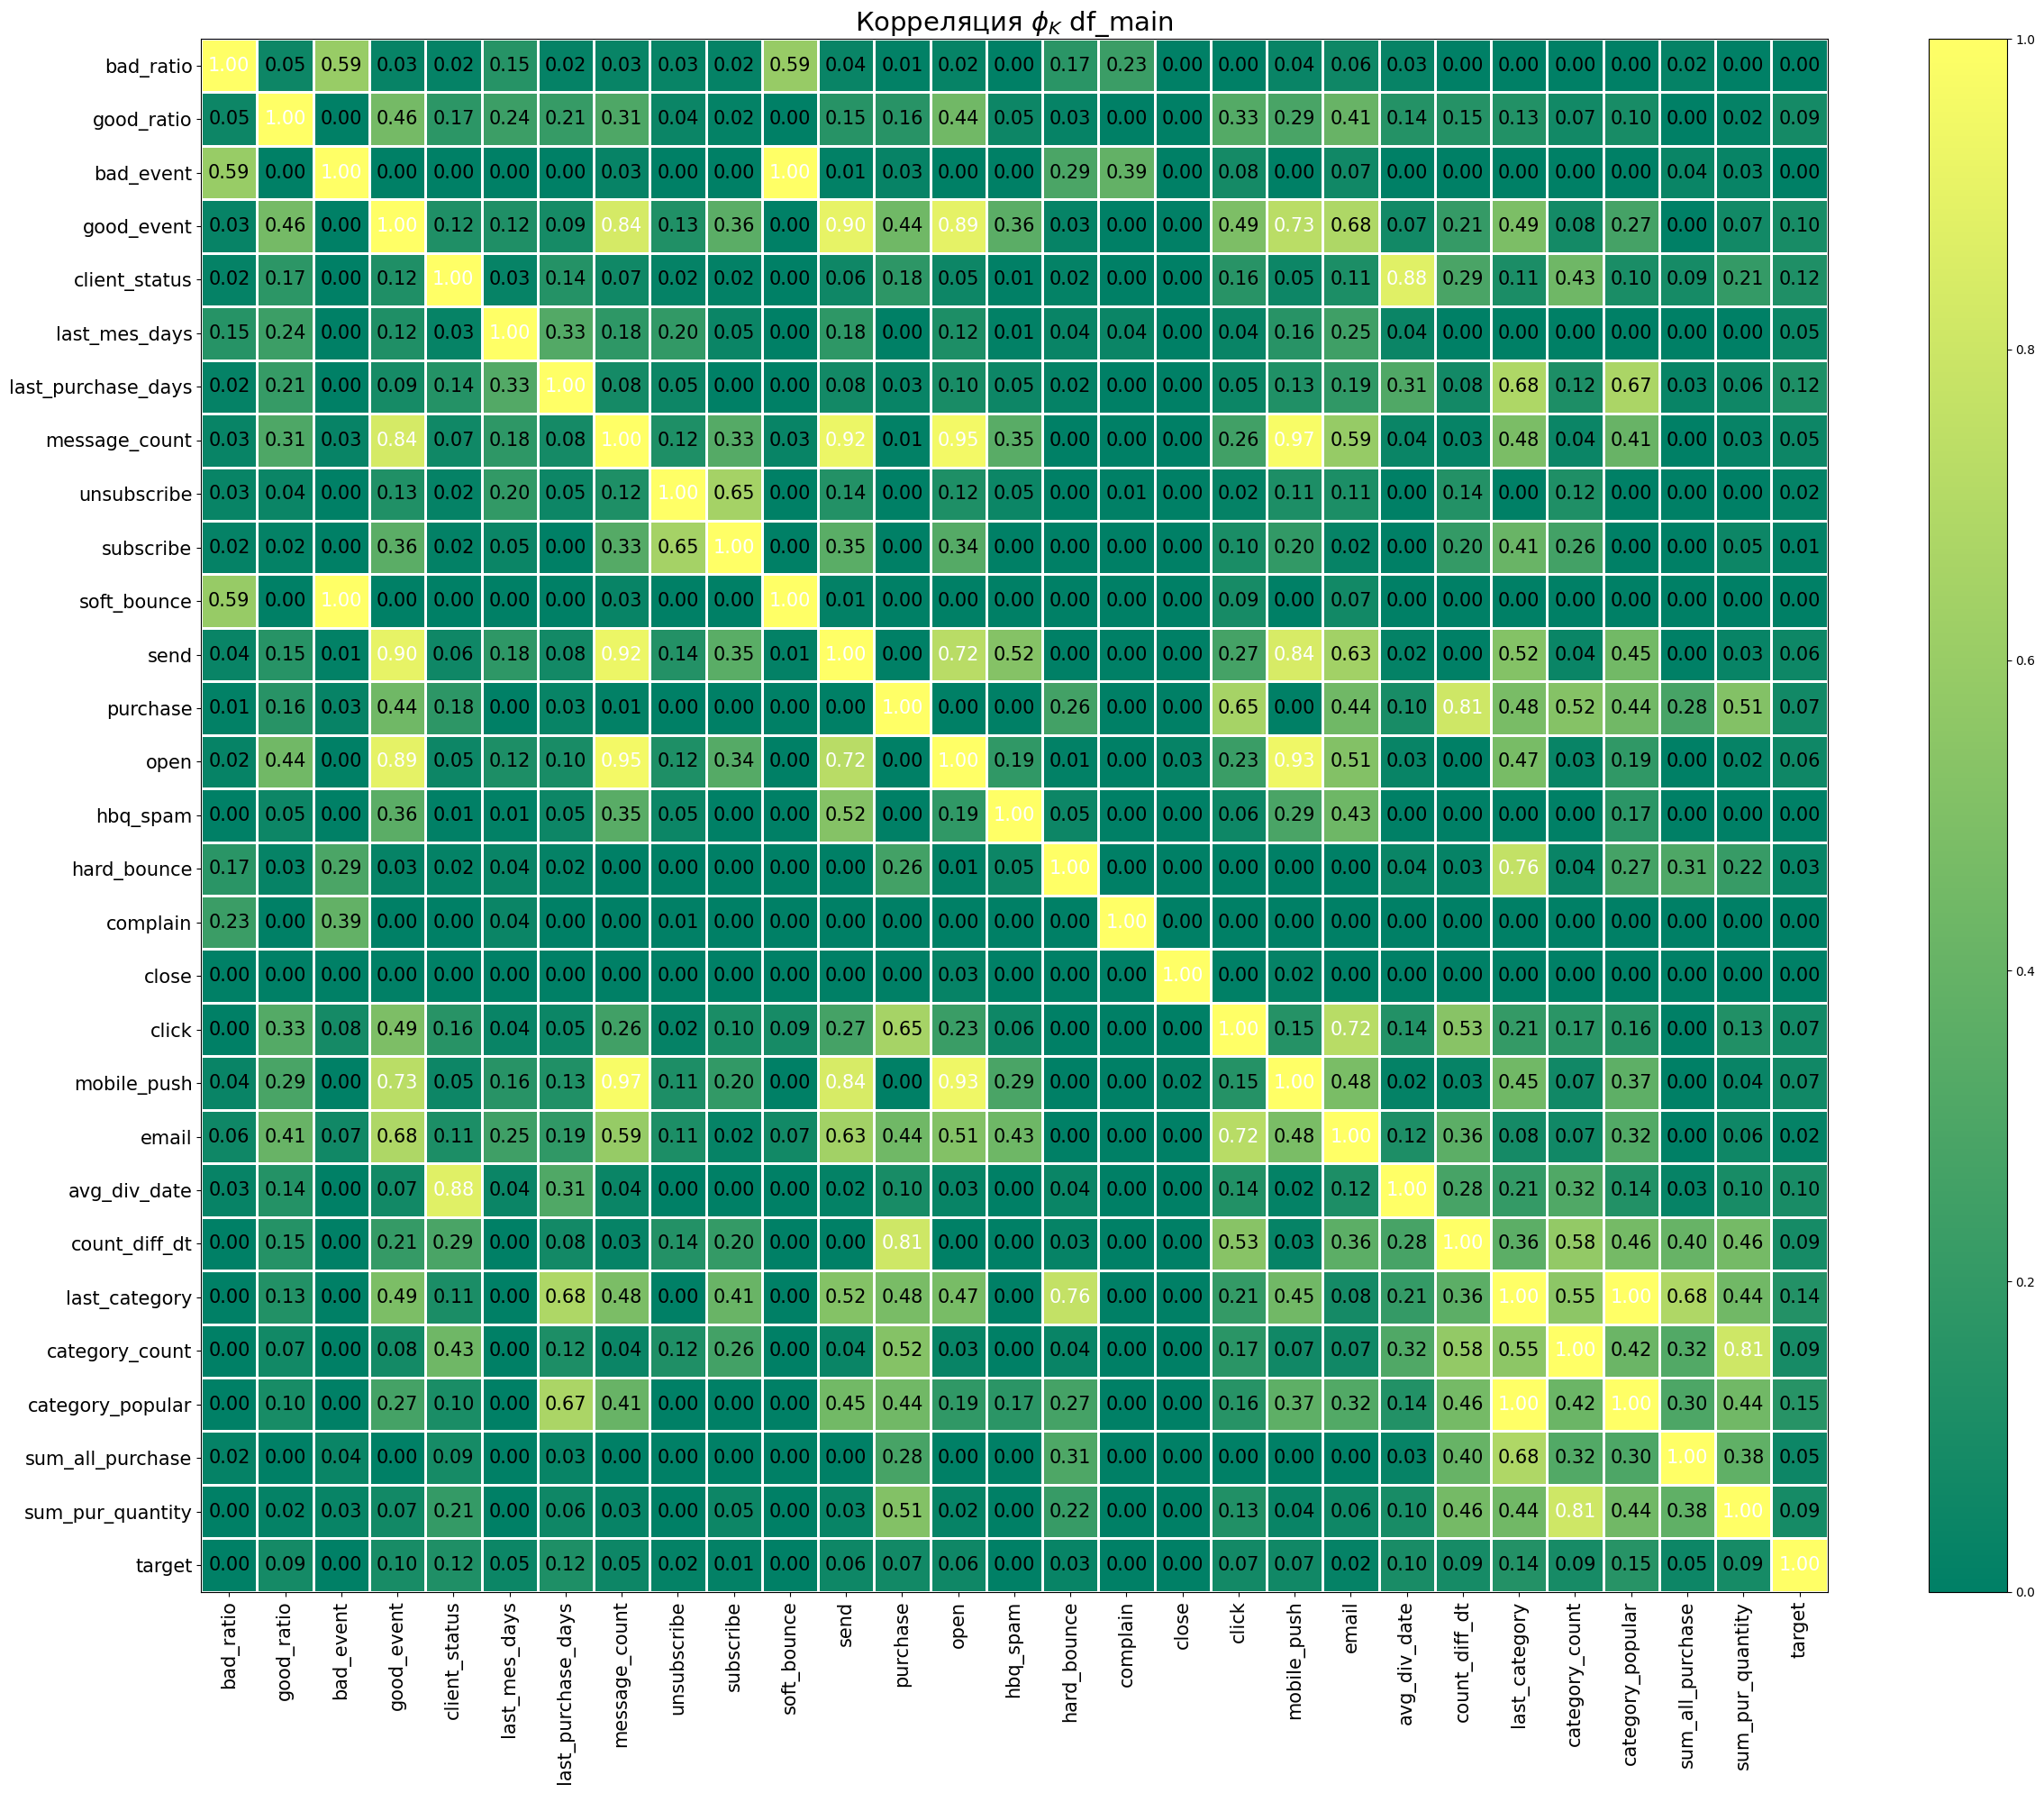

In [71]:
phik_overview = (
    df_main
    .phik_matrix(verbose=False, interval_cols=phik_col))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_main',
    fontsize_factor=1.5,
    figsize=(25, 20)
)

Избавимся от признаков с мультиколлинеарностью, а так же от тех, которые мало влияют на целевой признак.
Кроме того уберем все что связано с категориями товаров, как показала практика существенного вклада в точность предсказаний модели эти признаки не внесут.

In [72]:
df_main_2=df_main.copy()
df_main_2.drop(columns=[
 'close',
 'complain',
 'hbq_spam',
 'send',
 'soft_bounce',
 'subscribe',
 'unsubscribe',
 'message_count',
 'good_event',
 'bad_event',
 'last_category',
 'category_popular'
 ],inplace=True)

df_main_2.columns

Index(['target', 'sum_pur_quantity', 'sum_all_purchase', 'category_count',
       'count_diff_dt', 'avg_div_date', 'email', 'mobile_push', 'click',
       'hard_bounce', 'open', 'purchase', 'last_purchase_days',
       'last_mes_days', 'client_status', 'good_ratio', 'bad_ratio'],
      dtype='object')

In [73]:
phil_col_2=df_main_2.drop(['target',
                           'client_status',
                           ], axis=1).columns.to_list()
phil_col_2

['sum_pur_quantity',
 'sum_all_purchase',
 'category_count',
 'count_diff_dt',
 'avg_div_date',
 'email',
 'mobile_push',
 'click',
 'hard_bounce',
 'open',
 'purchase',
 'last_purchase_days',
 'last_mes_days',
 'good_ratio',
 'bad_ratio']

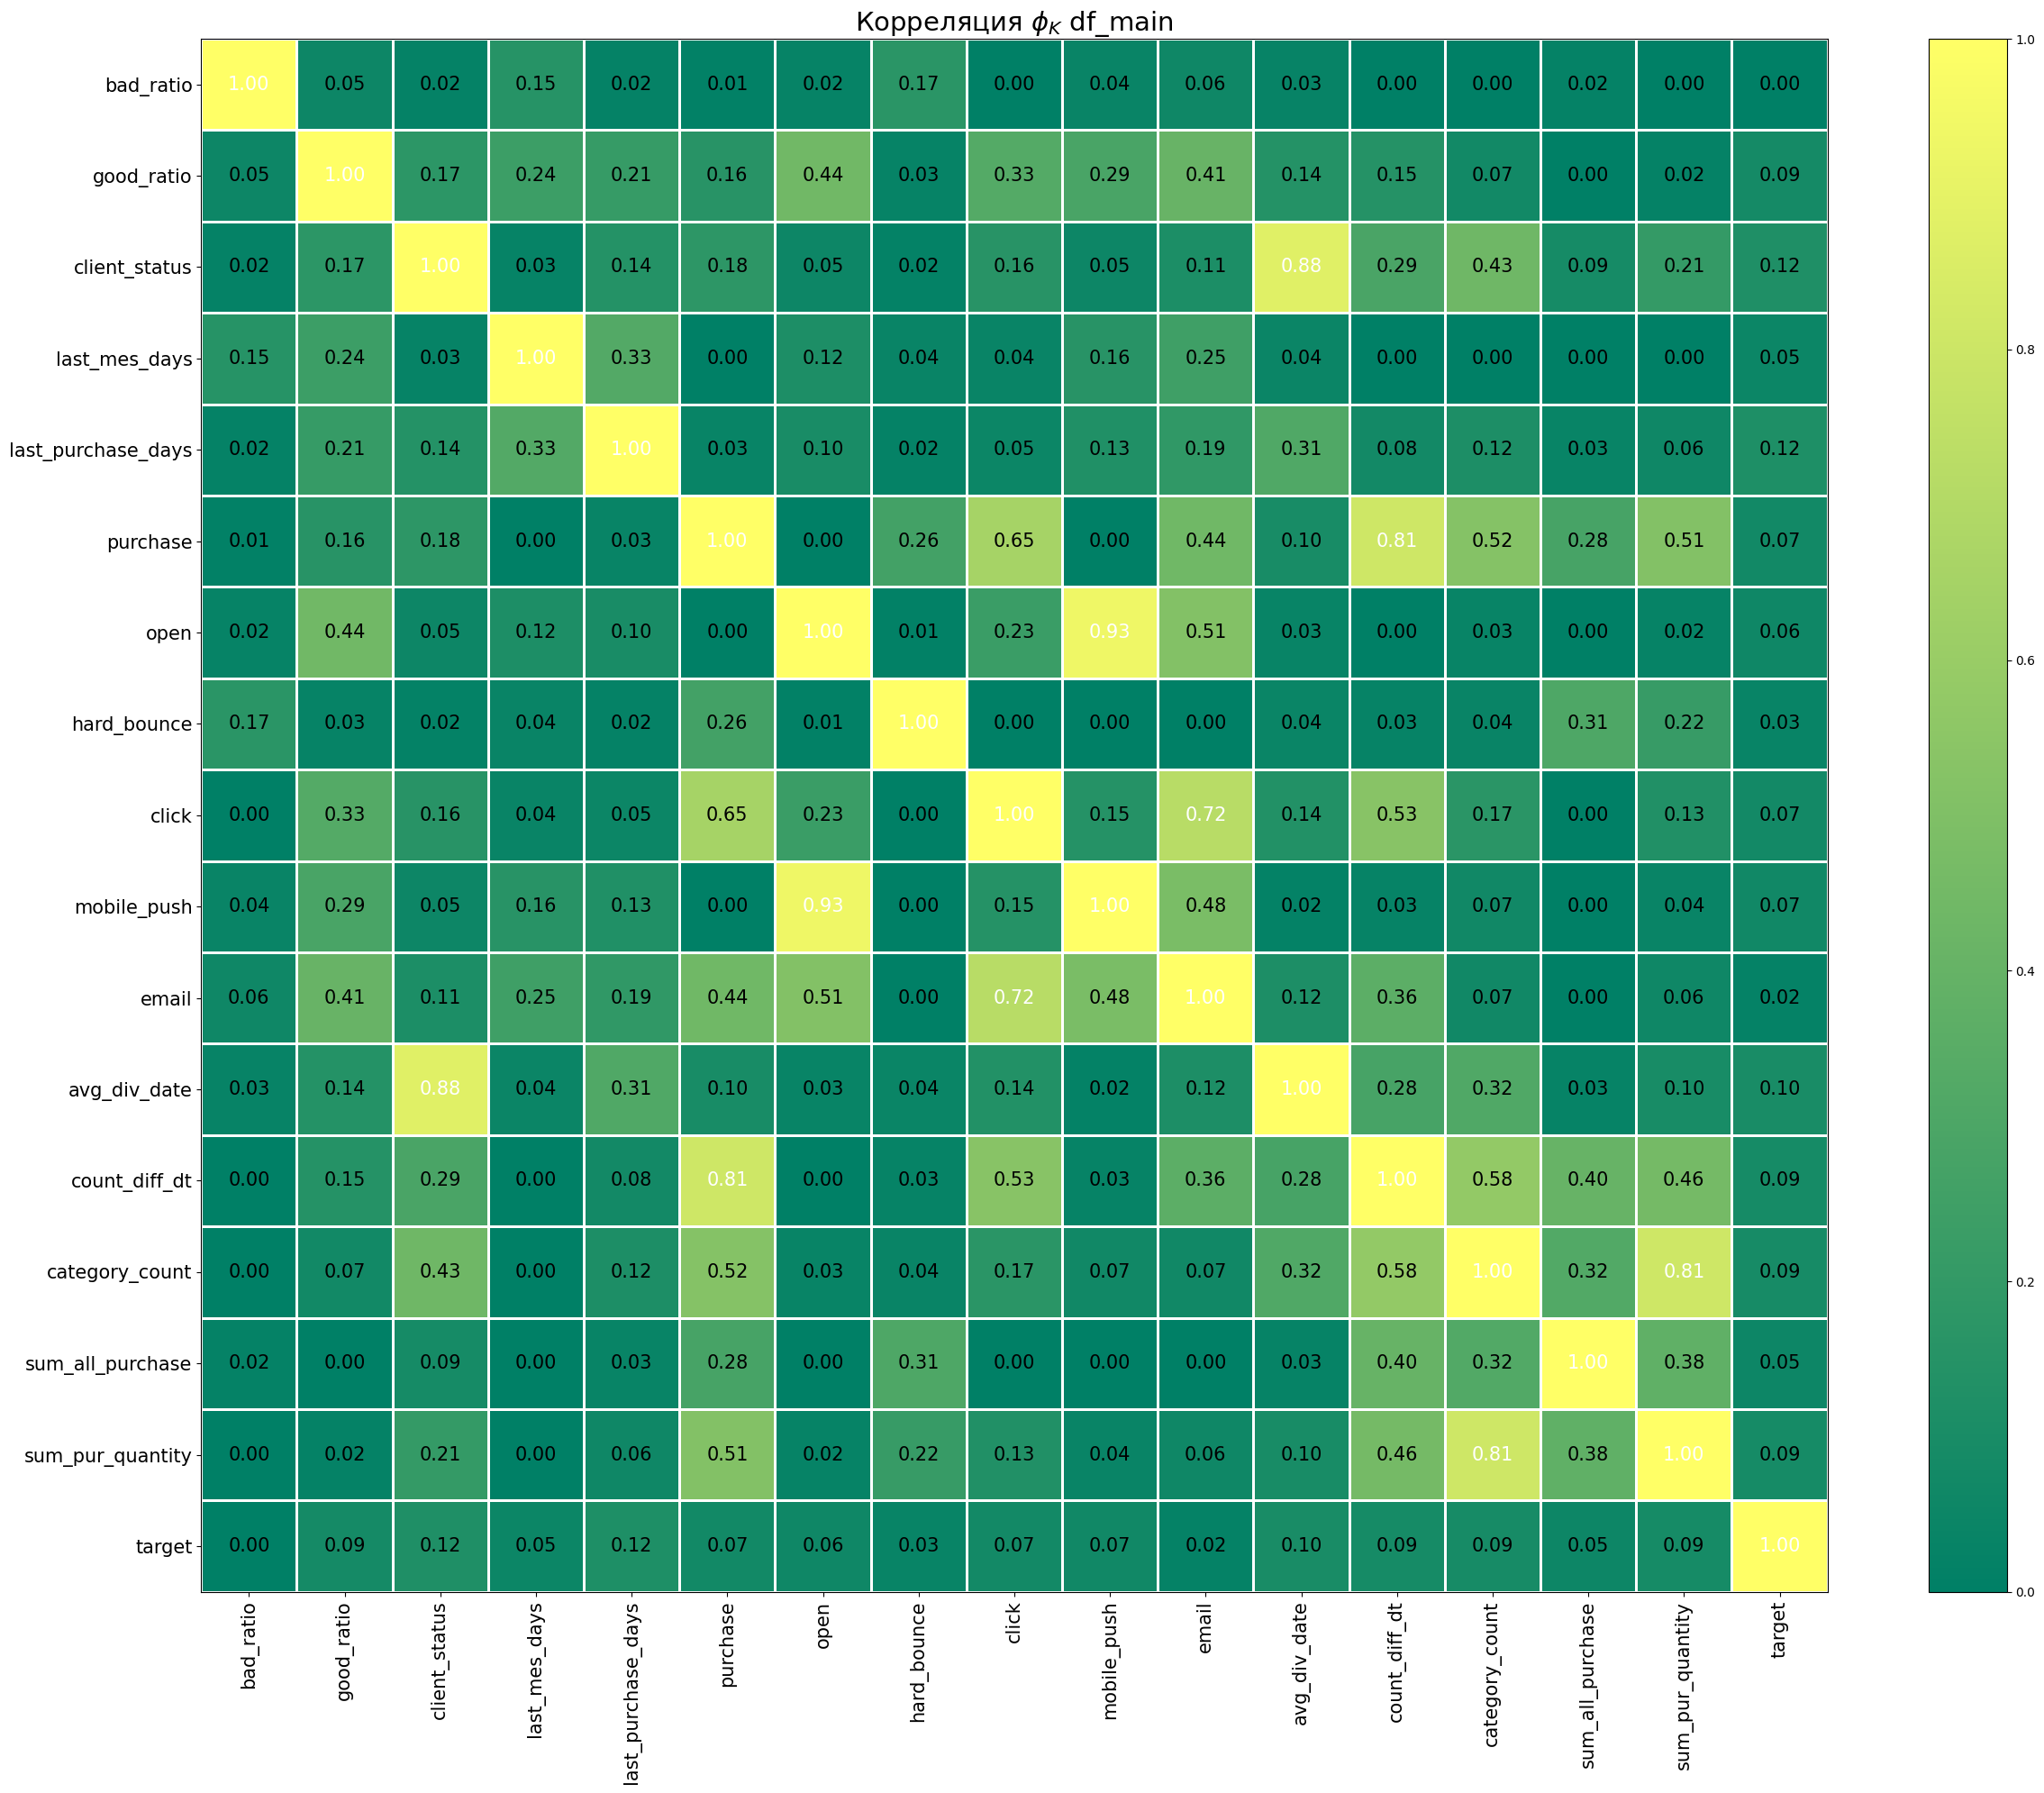

In [74]:
phik_overview = (
    df_main_2
    .phik_matrix(verbose=False, interval_cols=phil_col_2))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_main',
    fontsize_factor=1.5,
    figsize=(25, 20)
)

После достаточного большого количетва проб и ошибок, не все из которых отражены в исследовании, в целях его разумного сокращения, остановимся на следующих признаках для прогнозирования:
  - 'sum_pur_quantity'- общая сумма купленных товаров,
  - 'sum_all_purchase' - общая сумма денег потраченных клиентом,
  - 'category_count' - количество покупаемых клиентомкатегорий товаров,
  - 'count_diff_dt' -количетво повторных покупок клиента,
  - 'avg_div_date' - средняя временная разница между покупками,
  - 'email', 'mobile_push', 'click', 'hard_bounce', 'open', 'purchase' - сводная информация по рассылке для клиента,
  - 'last_purchase_days' - последняя дата покупки в днях,
  - 'last_mes_days' - последняя дама собщения клиенту в днях,
  - 'client_status' - статус клиента (постоянный или новый),
  - 'good_ratio', 'bad_ratio' - отношения позитивных/негативных событий рассылки для клиента.


## Моделирование

### Подготовка к моделированию

Исследую целевую переменную мы отмечали, что она очень несбалансирована, поэтому воспользуемся взвешиванием классов.

In [75]:
class_weights = compute_class_weight('balanced', classes=np.unique(df_main['target']), y=df_main['target'])

In [76]:
#разбиваем выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(df_main_2.drop(['target'],axis=True),
                                                    df_main_2['target'],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=df_main_2['target'])

In [77]:
X_train.head()

,sum_pur_quantity,sum_all_purchase,category_count,count_diff_dt,avg_div_date,email,mobile_push,click,hard_bounce,open,purchase,last_purchase_days,last_mes_days,client_status,good_ratio,bad_ratio
1515915625489118946,1,1999.0,1,1,0.0,264.0,220.0,19.0,1.0,138.0,1.0,336,246,new,0.326446,0.002066
1515915625965566170,2,1279.0,1,1,0.0,54.0,261.0,4.0,0.0,85.0,1.0,521,246,new,0.285714,0.000000
1515915625777399321,2,1958.0,1,1,0.0,0.0,186.0,6.0,0.0,0.0,1.0,296,247,new,0.037634,0.000000
1515915625588001323,1,1499.0,1,1,0.0,28.0,293.0,4.0,0.0,88.0,1.0,791,246,new,0.289720,0.000000
1515915625810310044,4,6296.0,2,2,1.0,0.0,97.0,3.0,2.0,8.0,2.0,839,370,constant,0.134021,0.020619


In [78]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)# проверка размеров

(31486, 16) (10496, 16) (31486,) (10496,)


Выборки подготовлены, размерность соблюдена, классы взвешены.

### Пайплайн

In [79]:
#DF для сравнений
df_scoring=pd.DataFrame(columns=['model_name', 'roc_auc_train'])

In [80]:

category_col=['client_status']

In [81]:
df_main_2.columns

Index(['target', 'sum_pur_quantity', 'sum_all_purchase', 'category_count',
       'count_diff_dt', 'avg_div_date', 'email', 'mobile_push', 'click',
       'hard_bounce', 'open', 'purchase', 'last_purchase_days',
       'last_mes_days', 'client_status', 'good_ratio', 'bad_ratio'],
      dtype='object')

In [82]:
# создаём списки с названиями признаков 
num_columns = ['sum_pur_quantity',
                'sum_all_purchase',
                'category_count',
                'count_diff_dt',
                'avg_div_date',
                'email',
                'mobile_push',
                'last_purchase_days',
                'last_mes_days',
                'good_ratio',
                'bad_ratio',
                'click',
                'hard_bounce',
                'purchase',
                'open',]

ohe_columns = ['client_status']

In [83]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


In [84]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_fin = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

### CatBoost

Используем для прогнозирования 2 модели бустинга - CatBoost и LGBM, а так же проверим модель логистической регрессии и лес решений. Для бустинга используем встроенные механизмы кодирования, для простых моделей создали заранее пайплайн.

In [85]:
pipe_cat = CatBoostClassifier(loss_function ='Logloss',
                             logging_level='Silent',
                             class_weights=dict(enumerate(class_weights)),
                             cat_features=category_col,
                             random_state=RANDOM_STATE)

In [86]:
param_cat = [
    # словарь для модели CatBoostRegressor()
    {
        'iterations': [50, 100],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 5],
    },  
]
search_cat = GridSearchCV(pipe_cat, param_cat, cv=7, scoring='roc_auc', verbose=1)# поиск оптимальных параметров

In [87]:
%%time
search_cat.fit(X_train, y_train)

Fitting 7 folds for each of 8 candidates, totalling 56 fits
CPU times: total: 1min 8s
Wall time: 1min 13s


GridSearchCV(cv=7,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E5692FF9D0>,
             param_grid=[{'depth': [4, 5], 'iterations': [50, 100],
                          'learning_rate': [0.01, 0.1]}],
             scoring='roc_auc', verbose=1)

In [88]:
best_cat=search_cat.best_estimator_
cross_params(search_cat)

Парамерты лучшей модели {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}
ROC-AUC с лучшими гиперпараметрами на кросс-валидации : 0.7584925636747927


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,0.758493,"{'depth': 4, 'iterations': 100, 'learning_rate...",0.828933
1,2,0.756020,"{'depth': 4, 'iterations': 50, 'learning_rate'...",1.083122
2,3,0.754476,"{'depth': 5, 'iterations': 100, 'learning_rate...",1.080020
3,4,0.754024,"{'depth': 5, 'iterations': 50, 'learning_rate'...",1.051641
4,5,0.746818,"{'depth': 5, 'iterations': 100, 'learning_rate...",1.074119


In [89]:
df_scoring.loc[len(df_scoring.index)]=('CatBoost', search_cat.best_score_)

### LGBMClassifier

In [90]:
X_train_l=X_train.copy()
X_test_l=X_test.copy()
X_train_l[category_col] = X_train_l[category_col].astype('category')
X_test_l[category_col] = X_test_l[category_col].astype('category')

In [104]:
mod_lgb = LGBMClassifier(random_seed=RANDOM_STATE,
                         class_weight=dict(enumerate(class_weights)),
                         verbosity=-1)

param_lgb = [{ 'learning_rate':[0.01, 0.05],
               'n_estimators': [100, 250],
               'max_depth': [3, 6],
    },
]

search_lgb = GridSearchCV(mod_lgb, param_lgb, cv=7, scoring='roc_auc', verbose=1)

In [105]:
%%time
search_lgb.fit(X_train_l, y_train)

Fitting 7 folds for each of 8 candidates, totalling 56 fits
CPU times: total: 52.4 s
Wall time: 17.2 s


GridSearchCV(cv=7,
             estimator=LGBMClassifier(class_weight={0: 0.5102829638273045,
                                                    1: 24.81205673758865},
                                      random_seed=42, verbosity=-1),
             param_grid=[{'learning_rate': [0.01, 0.05], 'max_depth': [3, 6],
                          'n_estimators': [100, 250]}],
             scoring='roc_auc', verbose=1)

In [106]:
best_lgb=search_lgb.best_estimator_
cross_params(search_lgb)
df_scoring.loc[len(df_scoring.index)]=('LightGBM', search_lgb.best_score_)

Парамерты лучшей модели {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
ROC-AUC с лучшими гиперпараметрами на кросс-валидации : 0.7529560123694831


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,0.752956,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.126571
1,2,0.748386,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.283960
2,3,0.743351,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.249116
3,4,0.740550,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.587095
4,5,0.735242,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.140713


### RandomForest

In [94]:


param_rfc= [
    {
    'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight=dict(enumerate(class_weights)))],
    'models__n_estimators' : [128, 160],
    'models__max_depth': [4, 6],
    'models__max_features': [1,2],#range(1, 9),
    'models__min_samples_split': [ 12, 15],#range(2, 15),
    'preprocessor__num': [StandardScaler()],# MinMaxScaler(), RobustScaler()]  

    },  
    
   
]
search_rfc = GridSearchCV(pipe_fin, param_rfc, cv=5, scoring='roc_auc', verbose=1)

In [96]:
%%time
search_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 1min 56s
Wall time: 2min 1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['client_status']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['sum_pur_quantity',
                                                                          'sum_a...
                                                                          'open'])])),
                                       ('models', LogisticRegression())]),
             param_grid=[{'models': [RandomForestClassifier(class_weight={0: 0.5102829638273045,
                                                                          1: 24.81205673758865},
                                                            random_state=42)],
                          'models__max_depth': [4, 6],
                          'models__max_features': [1, 2],
                          'models__min_samples_split': [12, 15],
                          'models__n_estimators': [128, 160],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='roc_auc', verbose=1)

In [97]:
best_rfc=search_rfc.best_estimator_
cross_params(search_rfc)
df_scoring.loc[len(df_scoring.index)]=('RandomForest', search_rfc.best_score_)

Парамерты лучшей модели {'models': RandomForestClassifier(class_weight={0: 0.5102829638273045,
                                     1: 24.81205673758865},
                       random_state=42), 'models__max_depth': 4, 'models__max_features': 2, 'models__min_samples_split': 15, 'models__n_estimators': 128, 'preprocessor__num': StandardScaler()}
ROC-AUC с лучшими гиперпараметрами на кросс-валидации : 0.7449454392948347


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,0.744945,{'models': RandomForestClassifier(class_weight...,1.290252
1,2,0.744863,{'models': RandomForestClassifier(class_weight...,1.602843
2,3,0.744751,{'models': RandomForestClassifier(class_weight...,1.359716
3,4,0.744714,{'models': RandomForestClassifier(class_weight...,1.632963
4,5,0.743709,{'models': RandomForestClassifier(class_weight...,2.177878


### LogisticRegression

In [98]:
param_log=[    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight= dict(enumerate(class_weights)),
        )],
        'models__solver': ['liblinear'],
        'models__penalty': ['l1', 'l2'],
        'models__C': [1,2,3],
        'preprocessor__num': [StandardScaler()]
    },]

search_log = GridSearchCV(pipe_fin, param_log, cv=10, scoring='roc_auc', verbose=1)

In [99]:
%%time
search_log.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
CPU times: total: 16.6 s
Wall time: 19.2 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['client_status']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['sum_pur_quantity',
                                                                          'sum_...
                                                                          'bad_ratio',
                                                                          'click',
                                                                          'hard_bounce',
                                                                          'purchase',
                                                                          'open'])])),
                                       ('models', LogisticRegression())]),
             param_grid=[{'models': [LogisticRegression(class_weight={0: 0.5102829638273045,
                                                                      1: 24.81205673758865},
                                                        random_state=42)],
                          'models__C': [1, 2, 3],
                          'models__penalty': ['l1', 'l2'],
                          'models__solver': ['liblinear'],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='roc_auc', verbose=1)

In [100]:
best_log=search_log.best_estimator_
cross_params(search_log)
df_scoring.loc[len(df_scoring.index)]=('LogisticRegression', search_log.best_score_)

Парамерты лучшей модели {'models': LogisticRegression(class_weight={0: 0.5102829638273045, 1: 24.81205673758865},
                   random_state=42), 'models__C': 1, 'models__penalty': 'l1', 'models__solver': 'liblinear', 'preprocessor__num': StandardScaler()}
ROC-AUC с лучшими гиперпараметрами на кросс-валидации : 0.7415353881262836


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,0.741535,{'models': LogisticRegression(class_weight={0:...,0.399308
1,2,0.741528,{'models': LogisticRegression(class_weight={0:...,0.413907
2,3,0.741527,{'models': LogisticRegression(class_weight={0:...,0.368138
3,4,0.741520,{'models': LogisticRegression(class_weight={0:...,0.269731
4,5,0.741516,{'models': LogisticRegression(class_weight={0:...,0.158352


## Проверка лучшей модели на тестовой выборке

На тренировочной путем кросс-валидации получили следующие результаты, будем отриентироваться на метрику roc_auc:

In [101]:
df_scoring

,model_name,roc_auc_train
0,CatBoost,0.758493
1,LightGBM,0.748429
2,RandomForest,0.744945
3,LogisticRegression,0.741535


Большой разницы в метриках к сожалению нет. С таким набором признаков все модели работают примерно одинаково, незначительно лучше цифры у CatBoost, проверим ее на тестовой выборке.

ROC-AUC =  0.7550146591517872
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     10284
           1       0.05      0.64      0.09       212

    accuracy                           0.74     10496
   macro avg       0.52      0.69      0.47     10496
weighted avg       0.97      0.74      0.83     10496



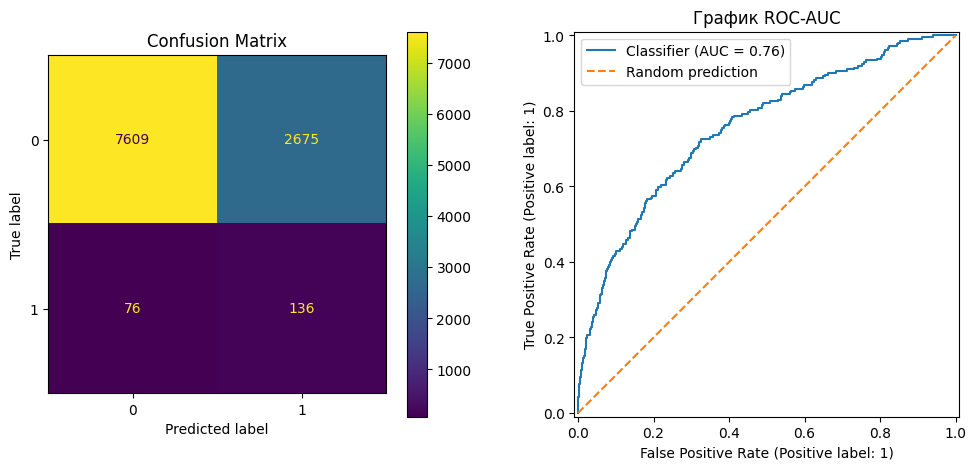

In [109]:
model_score(best_cat, X_test, y_test)

Посмотрим как справится с тестом деревянная модель:

ROC-AUC =  0.7531435074084675
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     10284
           1       0.05      0.59      0.10       212

    accuracy                           0.78     10496
   macro avg       0.52      0.68      0.48     10496
weighted avg       0.97      0.78      0.86     10496



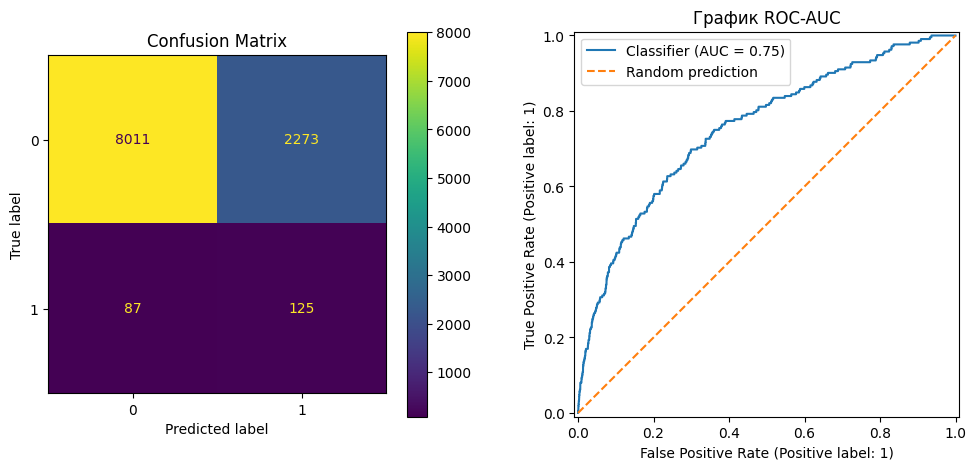

In [115]:
model_score(best_rfc, X_test_l, y_test)

Обе модели показали себя весьма средне, хоть мы и проходим пороговое значение roc_auc> 0.7, назвать предсказания точными весьма затруднительно. CatBoost лучше предсказывает 1 класс, RandomForest - 0.

Какую выбрать будет уже зависеть от конкретных целей компании на период, какой класс покупателей нам важнее. Привлечь новых лучшими акциями или сократить бюджет рассылки и сосредоточиться на более песпективных клиентах.

## Оценка значимости признаков

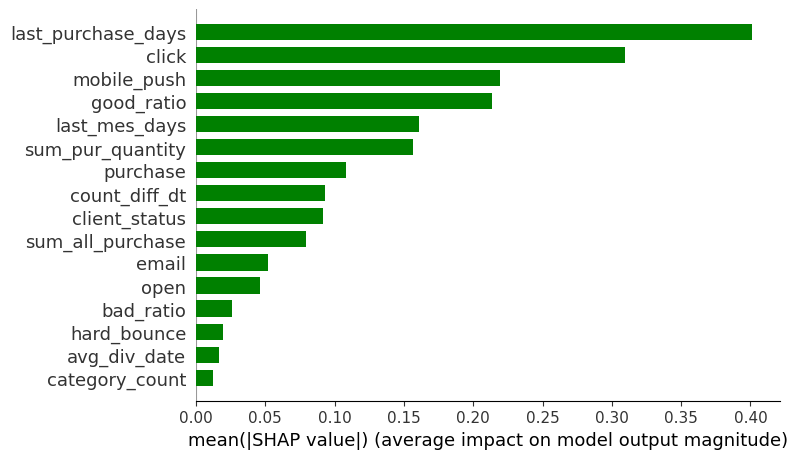

In [110]:
# Explain feature importance using SHAP
explainer = shap.Explainer(best_cat)
shap_values = explainer.shap_values(X_test)
 
# Create a summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size= 0.2, color='g')
plt.show()

Как видим на бустинговой модели наибольший вклад вносят дата отправки последнего сообщения, количество кликов совершенных клиентом и количество отправленных мобильных уведомлений.

# Итоговые выводы:


- загружены данные из трех файлов,
- данные обработаны от явных дубликатов,
- данные объеденены в один сводный датафрейм путем агрегации и добавления новых признаков,
- разработано 22 признака для итогового датафрейма, верно типизированных,с заполненными проблемами в данных и без дубликатов,
- лишние признаки удалены после анализа корреляцинной матрицы, так же удалены малоинформативные признаки,
- методом кросс валидации обучено 4 модели (2 модели бустинга, деревянная, логистическая регрессия) на 17 признаках,
- по итогам кросс-валидации лучшей выбрана бустинговая модель CatBostClassifier, метрика roc_auc 0.7584 на тренировочных данных,
- лучшая модель на тестовой выборке имееет показатель roc_auc - 0.76, что удовлетворяет условиям исследования,
- наиболее важные для можели признаки дата отправки последнего сообщения, количество кликов совершенных клиентом и количество отправленных мобильных уведомлений.




Учитывая, что мы достачно мало погружены в предментую область, прогноз вышел не впечатляющий. Для более точного исследования, стоит уточнить, что за товары продает фирма, какие акции и скидки предлагает в рекламных компаниях, есть ли бонусы постоянным клиентам, кроме того стоит уточнить данные расылок всех клиентов.Так же стоит уточнить цели исследования, для чего мы прогнозируем статус клиента, на точности определения какого класса стоит сосредоточиться.